# Slope detection Power

Slope detection power answers the question "What is the likelihood that we can detect a slope (for instance a reduction) in our future data given sampling frequencies?"

First we need to import some necessary libraries

In [33]:
from gw_detect_power import DetectionPowerSlope, AutoDetectionPowerSlope
import numpy as np
import matplotlib.pyplot as plt

# Running Simple Slope Detection Power

## Running Linear regression detection power

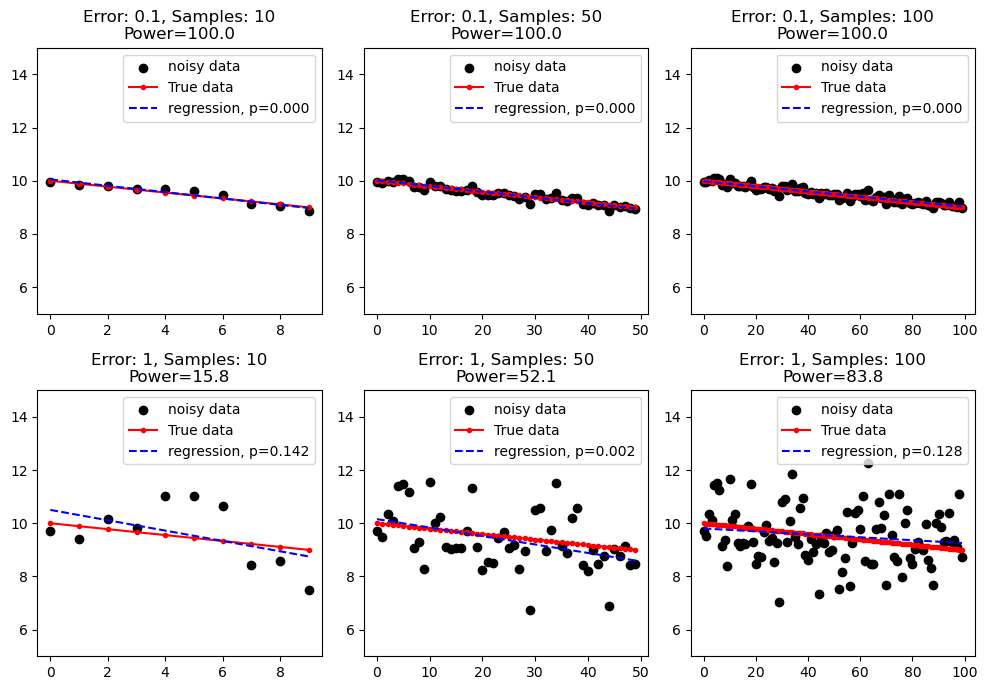

In [34]:
errors = [0.1, 1]
samples = [10, 50, 100]

dpc = DetectionPowerSlope(significance_mode='linear-regression', nsims=1000, min_p_value=0.05,
                          return_true_conc=True, return_noisy_conc_itters=1)

fig, axs = plt.subplots(nrows=len(errors), ncols=len(samples), figsize=(10, 7))

for i, error in enumerate(errors):
    for j, nsamp in enumerate(samples):
        # generate some random data
        x = np.linspace(0, 10, nsamp)
        y_true = -0.1 * x + 10
        out = dpc.power_calc('temp', error=error, true_conc_ts=y_true, seed=5654)
        fig0, ax = dpc.plot_iteration(y0=out['noisy_conc'].iloc[:, 0], true_conc=y_true, ax=axs[i,j])
        ax.set_title(f'Error: {error}, Samples: {nsamp}\nPower={out["power"].loc["power"]:.1f}')
        ax.set_ylim(5, 15)

fig.tight_layout()
plt.show()

## Running Mann Kendall detection power

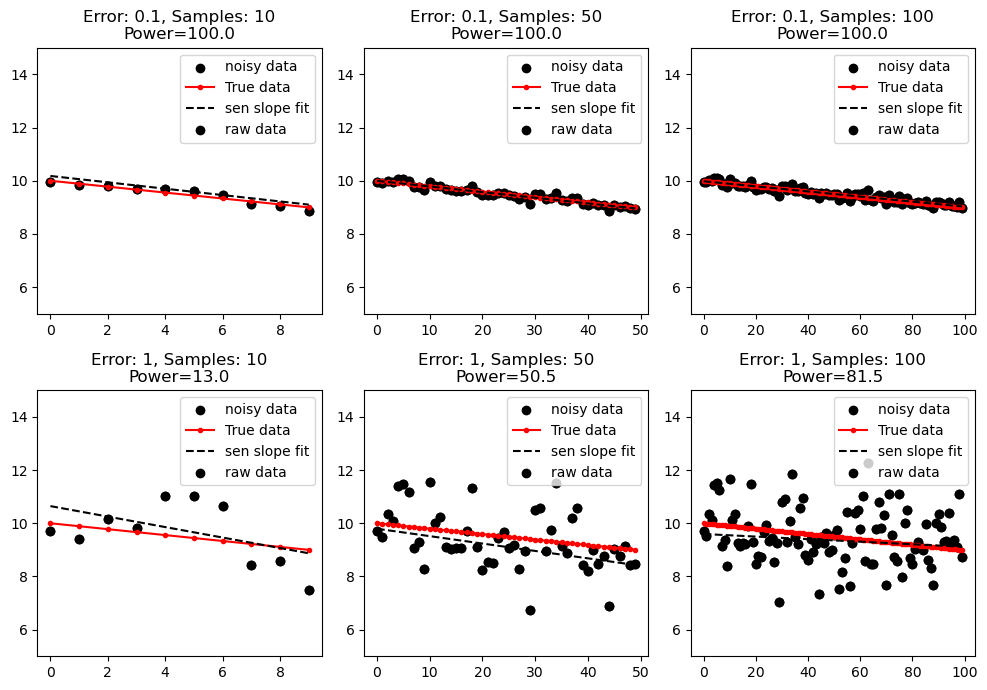

In [35]:
errors = [0.1, 1]
samples = [10, 50, 100]

dpc = DetectionPowerSlope(significance_mode='mann-kendall', nsims=1000, min_p_value=0.05,
                          return_true_conc=True, return_noisy_conc_itters=1)

fig, axs = plt.subplots(nrows=len(errors), ncols=len(samples), figsize=(10, 7))

for i, error in enumerate(errors):
    for j, nsamp in enumerate(samples):
        # generate some random data
        x = np.linspace(0, 10, nsamp)
        y_true = -0.1 * x + 10
        out = dpc.power_calc('temp', error=error, true_conc_ts=y_true, seed=5654)
        fig0, ax = dpc.plot_iteration(y0=out['noisy_conc'].iloc[:, 0], true_conc=y_true, ax=axs[i,j])
        ax.set_title(f'Error: {error}, Samples: {nsamp}\nPower={out["power"].loc["power"]:.1f}')
        ax.set_ylim(5, 15)

fig.tight_layout()
plt.show()

# Running Complex detection power

In a more complex slope detection power we can have a time series that increases for a while and then decreases. 

## Generating a complex time series

Here we generate a complex time series (via simple polynomial) that increases for a while and then decreases. This is a common pattern in environmental data, for instance where groundwater concentrations are lagged behind changes in input concentrations.

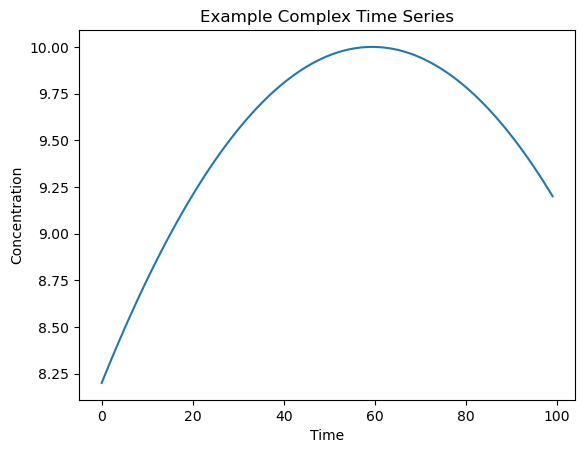

In [36]:
def generate_complex_ts(n):
    x = np.linspace(0, 10, n)
    y = -0.05*(x-6)**2 + 10
    return y

example_y = generate_complex_ts(100)
fig, ax = plt.subplots()
ax.plot(example_y)
ax.set_title('Example Complex Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
plt.show()

## The problem with monotonic tests

The challenge here is that the initial increase in concentration obscures the later decrease. This means that a monotonic test (such as Mann Kendall) will not be able to detect the decrease in concentration as easily. For instance even in the example below where there is no noise a Mann Kendall test will not be able to detect the decrease in concentration.

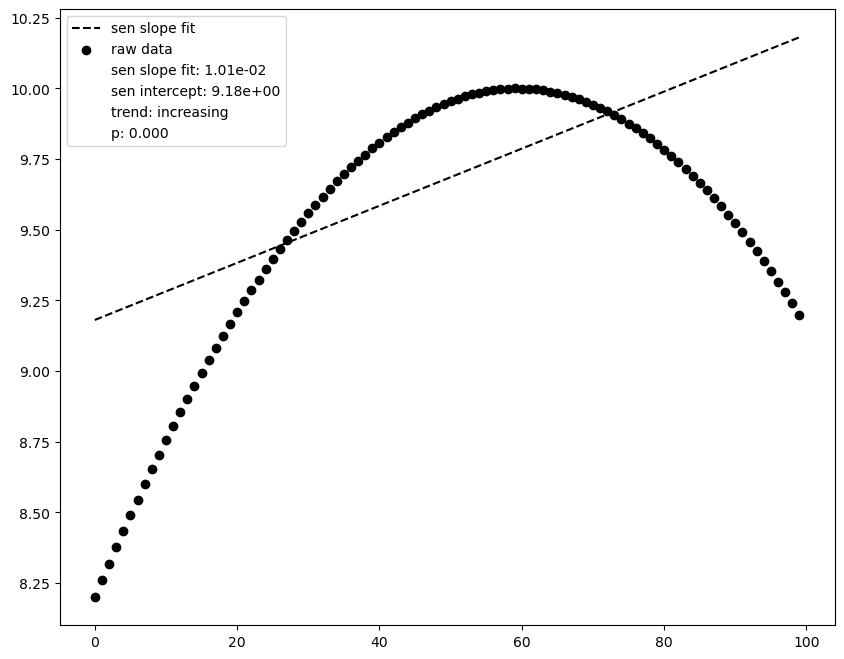

In [37]:
from kendall_stats import MannKendall

mk = MannKendall(example_y)
mk.plot_data()
plt.show()

If the data is noisy it can get even more difficult

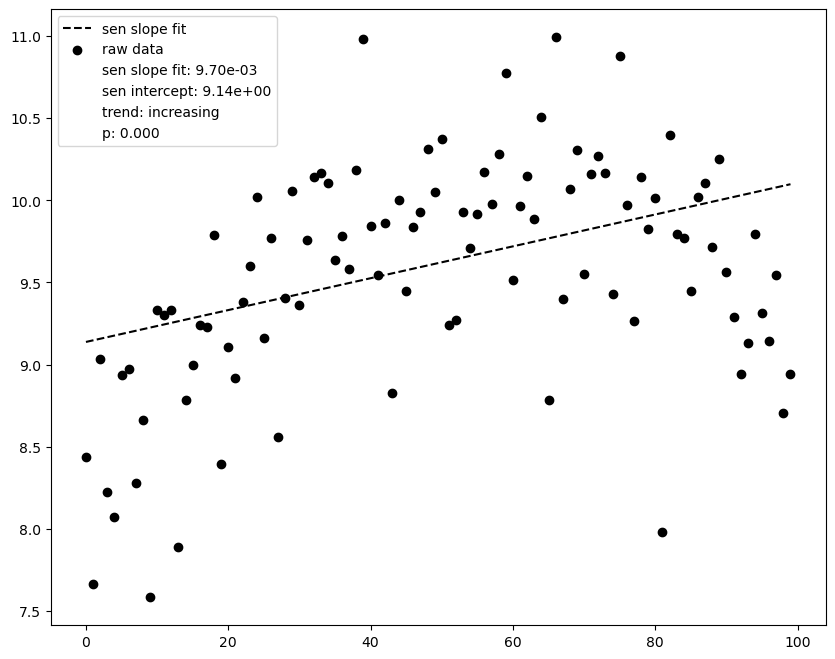

In [38]:
np.random.seed(1234)
noisy_y = example_y + np.random.normal(0, 0.5, len(example_y))
mk = MannKendall(noisy_y)
mk.plot_data()
plt.show()

## the "From Max" solution

The obvious solution is to run the monotonic test from the maximum/minimum value. This is implemented; is what the 'linear-regression-from-max',  'linear-regression-from-min', 'mann-kendall-from-max', 'mann-kendall-from-min', options do. This is a simple solution that works well, but it assumes that you know exactly when the maximum will happen. With noisy data that might be quite an assumption.

## The Multi-part Mann Kendall Solution

A better solution is to use a multi-part Mann Kendall test.  For this test the user specifies a number of segements and the slope that they would expect in each segment. The test then runs a Mann Kendall test on each possible segment and the best breakpoint is used. This is implemented in the 'mann-kendall-multi-part' option, the change is considered detected if the p-value of the Mann Kendall test is less than the set min_p_value.

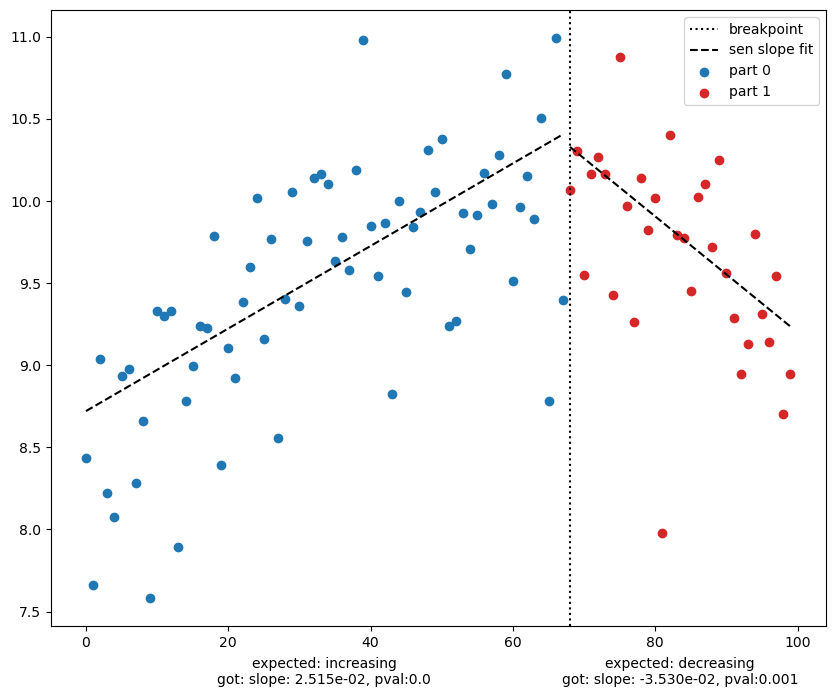

In [39]:
from kendall_stats import MultiPartKendall

mpmk = MultiPartKendall(noisy_y, nparts=2, expect_part=(1, -1))
mpmk.plot_data_from_breakpoints(mpmk.get_maxz_breakpoints())
plt.show()


## Running the complex detection power

Bringing it all together:

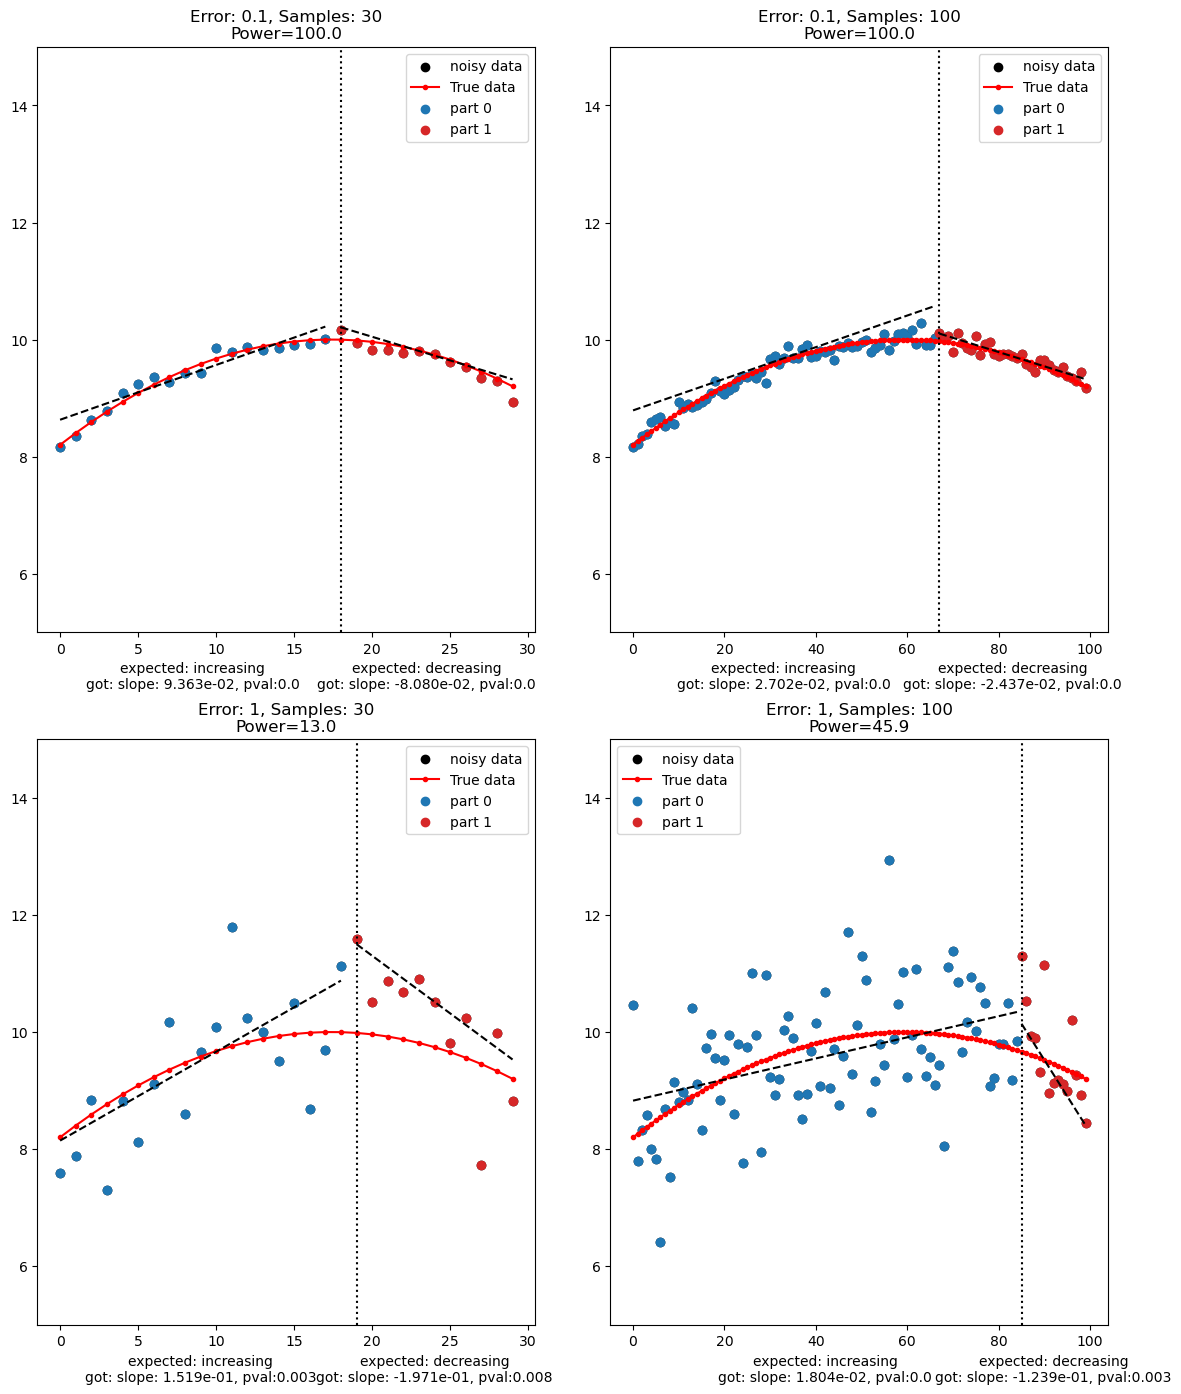

In [47]:
noises = [0.5, 1.5]
samples = [30, 100]

dpc = DetectionPowerSlope(significance_mode='n-section-mann-kendall', nsims=1000, min_p_value=0.05,
                          return_true_conc=True, return_noisy_conc_itters=1, nparts=2, expect_slope=(1, -1),
                          only_significant_noisy=True)
fig, axs = plt.subplots(nrows=len(errors), ncols=len(samples), figsize=(12, 14))

for i, error in enumerate(errors):
    for j, nsamp in enumerate(samples):
        # generate some random data
        y_true =generate_complex_ts(nsamp)
        out = dpc.power_calc('temp', error=error, true_conc_ts=y_true, seed=5654)
        fig0, ax = dpc.plot_iteration(y0=out['noisy_conc'].iloc[:, 0], true_conc=y_true, ax=axs[i,j])
        ax.set_title(f'Error: {error}, Samples: {nsamp}\nPower={out["power"].loc["power"]:.1f}')
        ax.set_ylim(5, 15)

fig.tight_layout()
plt.show()

## Auto Detection power mode

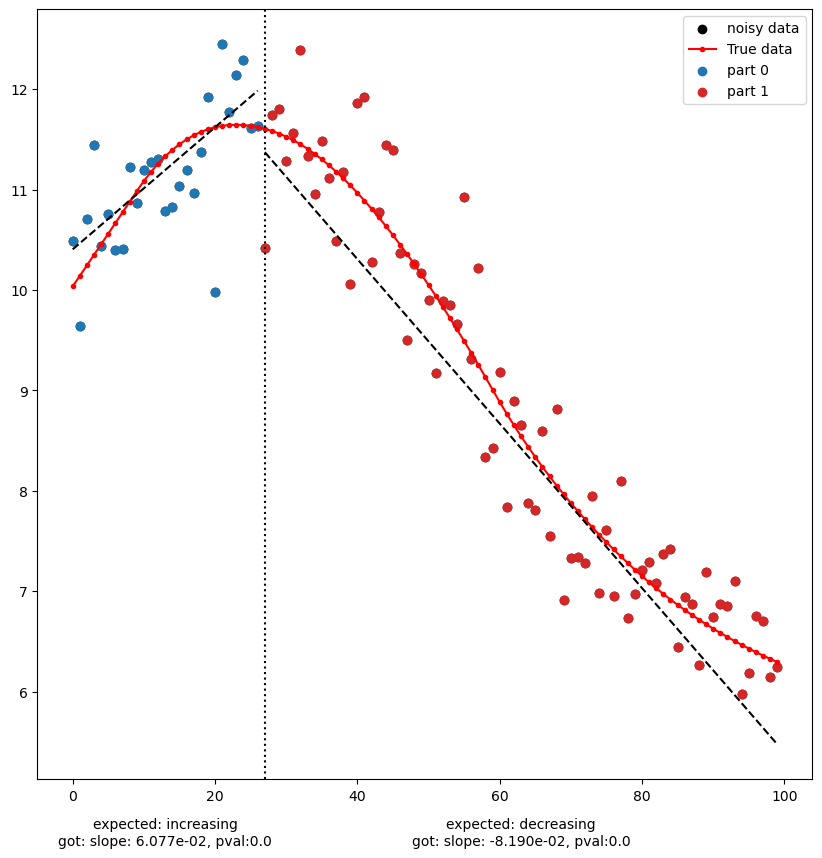

In [46]:
dpc = AutoDetectionPowerSlope(
    significance_mode='n-section-mann-kendall', nsims=1000,
    expect_slope=[1, -1], nparts=2, min_part_size=10, no_trend_alpha=0.50,
    return_true_conc=True, return_noisy_conc_itters=1)

out = dpc.power_calc(
    idv='true',
    error=0.5,
    mrt_model='binary_exponential_piston_flow',
    samp_years=10,
    samp_per_year=10,
    implementation_time=5,
    initial_conc=10,
    target_conc=5,
    prev_slope=1,
    max_conc_lim=25,
    min_conc_lim=1,
    mrt=5,
    #
    mrt_p1=3,
    frac_p1=0.7,
    f_p1=0.7,
    f_p2=0.7,
    #
    seed=558
)

dpc.plot_iteration(y0=out['noisy_conc'].iloc[:, 0], true_conc=out['true_conc'], ax=None)
plt.show()